In [12]:
#!/usr/bin/python
# encoding=utf8

import matplotlib.pyplot as plt
import numpy as np
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip

### external codes
from redTools import *
from Kcorrect import *
  
########################################################### Begin

inFile  = 'ESN_HI_catal.csv'   # input catalog
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

## purifying input data
index, = np.where(table['Sba']>0.01)
table = trim(table, index)

index, = np.where(table['Wba']>0.01)
table = trim(table, index)

index, = np.where(table['R50_g']>0)
table = trim(table, index)

index, = np.where(table['R50_r']>0)
table = trim(table, index)

index, = np.where(table['R50_w1']>0)
table = trim(table, index)

Sba = table['Sba']  # SDSS b/a
Wba = table['Wba']  # WISE b/a
Re_g = table['R50_g'] #half light radius for different bands
Re_r = table['R50_r']
Re_i = table['R50_i']
Re_z = table['R50_z']
Re_w1 = table['R50_w1']
Re_w2 = table['R50_w2']
Re_i_z = (1./2)*(Re_i + Re_z) #i+z half light radius

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [ ]:
## defining the linear fit
def linfit(x, m, b):
    return m * x + b

fit_g, cov_g = curve_fit(linfit, Re_g, Re_w1, p0=[1, 2])
fit_r, cov_r = curve_fit(linfit, Re_r, Re_w1, p0=[1, 2])
fit_i, cov_i = curve_fit(linfit, Re_i, Re_w1, p0=[1, 2])
fit_z, cov_z = curve_fit(linfit, Re_z, Re_w1, p0=[1, 2])

print 'g: ', fit_g, cov_g
print 'r: ', fit_r, cov_r
print 'i: ', fit_i, cov_i
print 'z: ', fit_z, cov_z
##print np.polyfit(Re_g, Re_w1, 1)

x = np.linspace(0.02,3,1000)

fig = py.figure(figsize=(10, 10), dpi=100)    
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.10, left=0.08, right=0.98) 
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.scatter(Re_g, Re_w1, c='k', alpha=0.1, marker='.') # black points
ax.text(0.1,2., '$m_g=$ '+'%.2f'%fit_g[0]+r'$\pm$'+'%.2f'%np.sqrt(cov_g[0][0]), fontsize=14, color='k')
ax.text(0.1,1.3, r'$b_\alpha=$ '+'%.2f'%fit_g[1], fontsize=14, color='k')
ax.plot(x, fit_g[0]*x+fit_g[1], 'g', label='Linear Trend')
ax.set_xlabel('$log_{10}(R_e)$'+' SDSS g-band [arcmin]', size=14)
ax.set_ylabel('$log_{10}(R_e)$'+' WISE w1-band [arcmin]', size=14)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.05,3])
ax.set_ylim([0.05,3])
for i in np.arange(0,2.5,0.1):
    xp = []
    yp = []
    for ii in range(len(Re_g)):
        xi = Re_g[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Re_w1[ii])
    if len(x)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='.', 
                    color='red', alpha=0.8)

logFit, cov = curve_fit(linfit, np.log10(Re_g), np.log10(Re_w1), p0=[1, 2])
ax.plot(x, 10**(logFit[0]*np.log10(x)+logFit[1]), 'blue')



g:  [0.70683582 0.07679767] [[ 2.77853795e-05 -1.05980308e-05]
 [-1.05980308e-05  6.60563037e-06]]
r:  [0.75957953 0.07231051] [[ 2.61748650e-05 -9.44511562e-06]
 [-9.44511562e-06  5.54263207e-06]]
i:  [0.77955779 0.06921226] [[ 2.53718946e-05 -9.02157272e-06]
 [-9.02157272e-06  5.18655627e-06]]
z:  [0.81490746 0.07021734] [[ 2.96992571e-05 -1.00655465e-05]
 [-1.00655465e-05  5.51821506e-06]]


Text(0.5,0,'$R_e$ SDSS proxy [arcmin]')

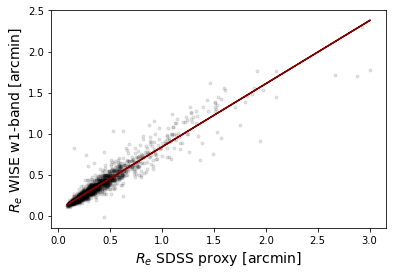

In [3]:
# Re_prox = np.m

Y = np.ones(shape = (4,len(Re_g)))
Y[0] = Re_g
Y[1] = Re_r
Y[2] = Re_i
Y[3] = Re_z
Re_prox = np.median(Y.T,1)

fit_prox, cov_prox = curve_fit(linfit, Re_prox, Re_w1, p0=[1, 2])
plt.scatter(Re_prox, Re_w1, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_prox, linfit(Re_prox, fit_prox[0], fit_prox[1]), 'maroon', label='Linear Trend')
plt.ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)
plt.xlabel('$R_e$'+' SDSS proxy [arcmin]', size=14)

Text(0,0.5,'$R_e$ WISE w1-band [arcmin]')

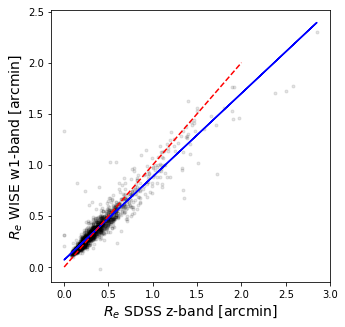

In [4]:
fit_z, zfitcov = curve_fit(linfit, Re_z, Re_w1, p0=[1, 2])

#z vs w1
fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_z, Re_w1, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_z, linfit(Re_z, fit_z[0], fit_z[1]), 'b') # blue linear fit
plt.plot([0,2],[0,2], 'r--')    # equality red line

plt.xlabel('$R_e$'+' SDSS z-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)

Text(0,0.5,'$R_e$ WISE w1-band [arcmin]')

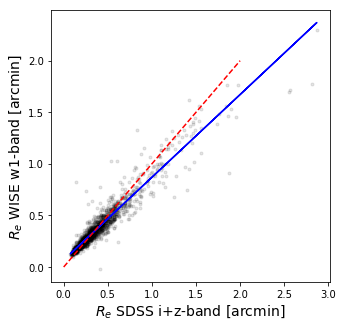

In [5]:
fit_i_z, izfitcov = curve_fit(linfit, Re_i_z, Re_w1, p0=[1, 2])

#i+z vs w1
fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_i_z, Re_w1, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_i_z, linfit(Re_i_z, fit_i_z[0], fit_i_z[1]), 'b') # blue linear fit
plt.plot([0,2],[0,2], 'r--')    # equality red line

plt.xlabel('$R_e$'+' SDSS i+z-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)

In [6]:
###Calculating Re_med
gri_list = []
gri_list.append(Re_g)
gri_list.append(Re_r)
gri_list.append(Re_i)
Re_gri = np.array(gri_list).T

for row in Re_medi:
    row = np.arange(0, 2233, 1)
    Re_med = np.array(np.median(Re_gri[row,:],axis=1))
#################################################################

NameError: name 'Re_medi' is not defined

In [ ]:
#Re_med vs Re_z

fit_medz, medzfitcov = curve_fit(linfit, Re_z, Re_med, p0=[1, 2])

fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_z, Re_med, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_z, linfit(Re_z, fit_medz[0], fit_medz[1]), 'b', label='Linear Trend') # blue linear fit
plt.plot(Re_z, linfit(Re_z, fit_medz[0], fit_medz[1]+.5), 'g:', label='$\pm$ 0.5 arcmin') # blue linear fit
plt.plot(Re_z, linfit(Re_z, fit_medz[0], fit_medz[1]-.5), 'g:') # blue linear fit

#plt.plot([0,2],[0,2], 'r--')    # equality red line
#arange = np.arange(0, 3, 1)
#plt.plot(arange+.5, arange, 'g--')
#plt.plot(arange-.5, arange, 'g--')

plt.xlabel('$R_e$'+' SDSS z-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' SDSS Median Half-light Radius [arcmin]', size=14)
plt.legend()

In [ ]:
#Re_med vs Re_i

fit_medi, medifitcov = curve_fit(linfit, Re_i, Re_med, p0=[1, 2])

fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_i, Re_med, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_i, linfit(Re_i, fit_medi[0], fit_medi[1]), 'b', label='Linear Trend') # blue linear fit
plt.plot(Re_i, linfit(Re_i, fit_medi[0], fit_medi[1]+.5), 'g:', label='$\pm$ 0.5 arcmin') # blue linear fit
plt.plot(Re_i, linfit(Re_i, fit_medi[0], fit_medi[1]-.5), 'g:') # blue linear fit

plt.xlabel('$R_e$'+' SDSS i-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' SDSS Median Half-light Radius [arcmin]', size=14)
plt.legend()

In [ ]:
#Re_med vs Re_r

fit_medr, medrfitcov = curve_fit(linfit, Re_r, Re_med, p0=[1, 2])

fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_r, Re_med, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_r, linfit(Re_r, fit_medr[0], fit_medr[1]), 'b', label='Linear Trend') # blue linear fit
plt.plot(Re_r, linfit(Re_r, fit_medr[0], fit_medr[1]+.5), 'g:', label='$\pm$ 0.5 arcmin') # blue linear fit
plt.plot(Re_r, linfit(Re_r, fit_medr[0], fit_medr[1]-.5), 'g:') # blue linear fit

plt.xlabel('$R_e$'+' SDSS r-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' SDSS Median Half-light Radius [arcmin]', size=14)
plt.legend()

In [ ]:
#Re_med vs Re_g

fit_medg, medgfitcov = curve_fit(linfit, Re_g, Re_med, p0=[1, 2])

fig = plt.figure(figsize=(5, 5))
plt.scatter(Re_g, Re_med, c='k', alpha=0.1, marker='.') # black points
plt.plot(Re_g, linfit(Re_g, fit_medg[0], fit_medg[1]), 'b', label='Linear Trend') # blue linear fit
plt.plot(Re_g, linfit(Re_g, fit_medg[0], fit_medg[1]+.5), 'g:', label='$\pm$ 0.5 arcmin') # blue linear fit
plt.plot(Re_g, linfit(Re_g, fit_medg[0], fit_medg[1]-.5), 'g:') # blue linear fit

plt.xlabel('$R_e$'+' SDSS g-band [arcmin]', size=14)
plt.ylabel('$R_e$'+' SDSS Median Half-light Radius [arcmin]', size=14)
plt.legend()

In [ ]:
#if abs(Re_med-Re_z)>0.5: use Re_r otherwise Re_z is good and return its value together with the band name, i.e. 'z'
if abs(Re_med-Re_z)<0.5:
    
elif abs(Re_med-Re_r)>0.5:
    
elif abs(Re_med-Re_i)>0.5:
    
else:
    